In [1]:
import contractions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 

In [2]:
#load data on news articles
articles_df1 = pd.read_csv(r'C:\Users\mitch\OneDrive\Documents\Projects\news_article_analysis\articles1.csv')
articles_df2 = pd.read_csv(r'C:\Users\mitch\OneDrive\Documents\Projects\news_article_analysis\articles2.csv')
articles_df3 = pd.read_csv(r'C:\Users\mitch\OneDrive\Documents\Projects\news_article_analysis\articles3.csv')

#merge dataframes
frames = [articles_df1, articles_df2, articles_df3]
articles_df = pd.concat(frames).reset_index(drop=True)

#drop first column
articles_df.drop(articles_df.columns[0], axis=1, inplace=True)

In [3]:
articles_df.publication.unique()

array(['New York Times', 'Breitbart', 'CNN', 'Business Insider',
       'Atlantic', 'Fox News', 'Talking Points Memo', 'Buzzfeed News',
       'National Review', 'New York Post', 'Guardian', 'NPR', 'Reuters',
       'Vox', 'Washington Post'], dtype=object)

In [4]:
#investigate duplicate articles
dupes = articles_df.groupby(['title'])['id'] \
                   .count() \
                   .reset_index(name='count') \
                   .sort_values(['count'], ascending=False) \
                   .head(10)

#drop duplicates from df
articles_df.drop_duplicates(subset=['title', 'content', 'publication'], 
                            keep='first', inplace=True)

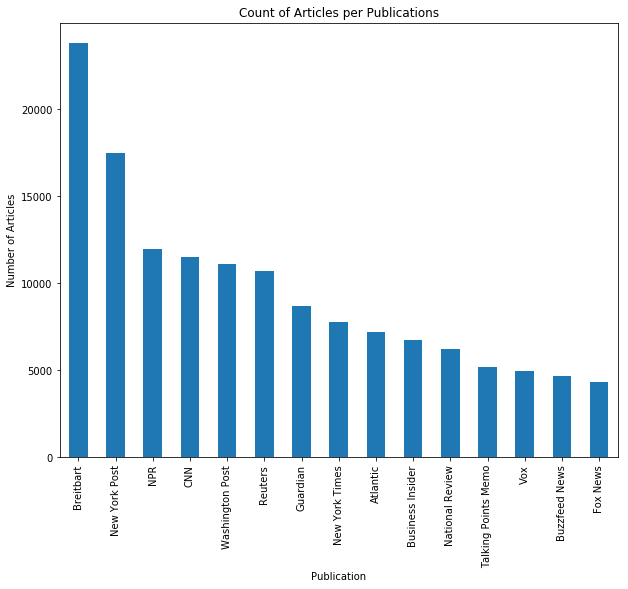

Breitbart              23781
New York Post          17493
NPR                    11992
CNN                    11488
Washington Post        11114
Reuters                10710
Guardian                8681
New York Times          7803
Atlantic                7178
Business Insider        6735
National Review         6203
Talking Points Memo     5210
Vox                     4942
Buzzfeed News           4661
Fox News                4353
Name: publication, dtype: int64

In [5]:
#plot count of publications
ax = articles_df['publication'].value_counts().plot(kind='bar',
                                    figsize=(10,8),
                                    title="Count of Articles per Publications")

#set labels
ax.set_xlabel('Publication')
ax.set_ylabel('Number of Articles')
plt.show()

#publication count table
articles_df['publication'].value_counts()

In [6]:
#dictionary for publication bias, source https://mediabiasfactcheck.com/
pub_bias_dict = {
    'Breitbart': 'Extreme - Right', 'New York Post': "Center - Right", 
    'NPR': 'Center - Left', 'CNN': 'Left', 'Washington Post': 'Center - Left', 
    'Reuters': 'Unbiased', 'Guardian' : 'Center - Left', 'New York Times': 'Center - Left', 
    'Atlantic': 'Center - Left', 'Business Insider': 'Center - Left', 'National Review' : 'Right', 
    'Talking Points Memo': 'Left', 'Vox': 'Left', 'Buzzfeed News': 'Center - Left', 
    'Fox News': 'Right'
    }

#assign bias a number label
bias_2_num = {
    'Extreme - Right': 0, 'Right': 1, 'Center - Right': 2, 
    'Unbiased': 3, 'Center - Left': 4, 'Left': 5
    }

#map bias to publication and bias to number label in new column
articles_df['publication_bias'] = articles_df['publication'].map(pub_bias_dict) #bias
articles_df['bias_label'] = articles_df['publication_bias'].map(bias_2_num) #bias number label

articles_df['publication_bias'].value_counts()

Center - Left      58164
Extreme - Right    23781
Left               21640
Center - Right     17493
Unbiased           10710
Right              10556
Name: publication_bias, dtype: int64

In [7]:
def preprocess_text(text):
    """cleans data to remove punctuation, caps, special characters, etc"""
    text = contractions.fix(text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = ''.join(c for c in text if not c.isdigit()) #remove numbers
    text = re.sub(' +',' ', text) #eliminate excess whitespace
    text = text.lower()
    
    return text


def remove_publication(content):
    """function removes publication names from text"""
    text = re.compile("\\b(New York Times|Washington Post|Guardian|Buzzfeed|\
                         |NPR|Business Insider|Atlantic|New York Post|Breitbart|\
                         |CNN|Vox|Talking Points Memo|National Review|Fox|Reuters)\\W", re.I)
    
    text = text.sub("", content)
    
    return text


def tokenize_remove_stopwords(text):
    """tokenizes text and removes stop words"""
    tokenizer = RegexpTokenizer('\s+', gaps=True) #init tokenizer
    tokens = tokenizer.tokenize(text) #create tokens
    
    # eliminate stop words from text
    cached_stop_words = stopwords.words("english")
    text = [w for w in tokens if not w in cached_stop_words] 
    
    return text


def lemmatize_tokenize(text):
    """tokenizes text and removes stop words"""
    tokenizer = RegexpTokenizer('\s+', gaps=True)
    lemmatizer = WordNetLemmatizer()
    
    tokens = [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)] #lemmatize & tokenize
    
    cached_stop_words = stopwords.words("english")
    text = [w for w in tokens if not w in cached_stop_words]  #remove stopwords
    
    return text 

In [8]:
#create new column to store the original text & another for the preprocessed text
articles_df.rename(columns={'content': 'original_content'}, inplace=True)
articles_df['processed_content'] = articles_df['original_content']

#apply preprocessing and tokenizing functions to column of content
articles_df['processed_content'] = articles_df['processed_content'].apply(lambda x: preprocess_text(x)) # clean text
articles_df['processed_content'] = articles_df['processed_content'].apply(lambda x: remove_publication(x)) # remove publication name
#articles_df['content_lemmatized'] = articles_df['processed_content'].apply(lambda x: lemmatize_tokenize(x)) # tokenize and lemmatize content
articles_df['processed_content'] = articles_df['processed_content'].apply(lambda x: tokenize_remove_stopwords(x)) # tokenize content

In [9]:
#create equal sample for model creation 
articles_df_60k = articles_df.groupby('publication_bias', group_keys=False).apply(lambda x: x.sample(10000)).reset_index()

In [10]:
# list of tokens from text documents
tokens_raw = articles_df_60k['processed_content']
#tokens_lemma = articles_df_60k['content_lemmatized']

# initialize vectorizer for raw and lemmatized tokens
vectorizer_raw = TfidfVectorizer(sublinear_tf=True, min_df=5, lowercase=False, 
                                 encoding='latin-1', ngram_range=(1, 2), analyzer=lambda x: x)

vectorizer_lemma = TfidfVectorizer(sublinear_tf=True, min_df=5, lowercase=False, 
                                   encoding='latin-1', ngram_range=(1, 2), analyzer=lambda x: x)

# build vocab and encode document
features_raw = vectorizer_raw.fit_transform(tokens_raw)
#features_lemma = vectorizer_lemma.fit_transform(tokens_lemma)

labels = articles_df_60k['bias_label'] #labels from target set

In [11]:
features_raw.shape

(60000, 61420)

In [12]:
X = features_raw # raw tokens
y = labels #bias labels

# splitting the data into train / test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#splitting the train data into train / cross validation 


In [13]:
def score_model(model):
    #
    predicted = model.predict(X_test)
    actual = y_test
    cf_matrix = confusion_matrix(actual, predicted)
    
    # print model's performance scores
    print('Accuracy Score :', accuracy_score(actual, predicted).round(3)) # accuracy
    print('')
    print('Report :', classification_report(actual, predicted), sep='\n') # precision, recall, f1-score

    # heatmap for confusion matrix
    xy_ticks = ['Left', 'Center - Left', 'Unbiased', 
                 'Center - Right', 'Right', 'Extreme - Right']

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=xy_ticks,  yticklabels=xy_ticks) #confusion matrix


    plt.title('Model Confusion Matrix', fontsize=15) # title with fontsize 20
    plt.xlabel('Predicted', fontsize=15) # x-axis label with fontsize 15
    plt.ylabel('Actual', fontsize=15) # y-axis label with fontsize 15

    plt.show()

In [14]:
# initiate svm model
svm = LinearSVC(multi_class='ovr', random_state=42, max_iter=1000)

# fit model
model_svm = svm.fit(X_train, y_train)

Accuracy Score : 0.774

Report :
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      3232
           1       0.78      0.79      0.78      3243
           2       0.72      0.77      0.75      3236
           3       0.98      0.99      0.99      3361
           4       0.66      0.63      0.64      3365
           5       0.66      0.65      0.66      3363

   micro avg       0.77      0.77      0.77     19800
   macro avg       0.77      0.77      0.77     19800
weighted avg       0.77      0.77      0.77     19800



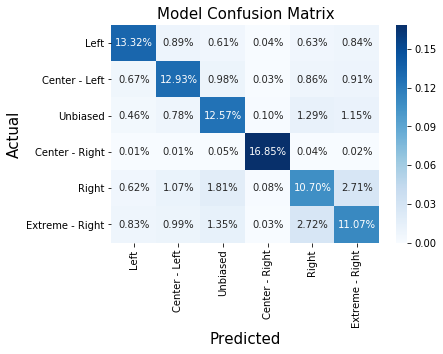

In [15]:
score_model(model_svm)

In [16]:
X_train.shape

(40200, 61420)

In [33]:
SVModel = SVC(decision_function_shape='ovr', random_state=42, gamma=0.001, C=1000, max_iter=20000)

SVModel.fit(X_train, y_train)

C:\Users\mitch\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=20000, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

Accuracy Score : 0.765

Report :
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      3232
           1       0.76      0.77      0.76      3243
           2       0.72      0.77      0.74      3236
           3       0.99      0.99      0.99      3361
           4       0.65      0.62      0.64      3365
           5       0.66      0.63      0.65      3363

   micro avg       0.76      0.76      0.76     19800
   macro avg       0.76      0.77      0.76     19800
weighted avg       0.76      0.76      0.76     19800



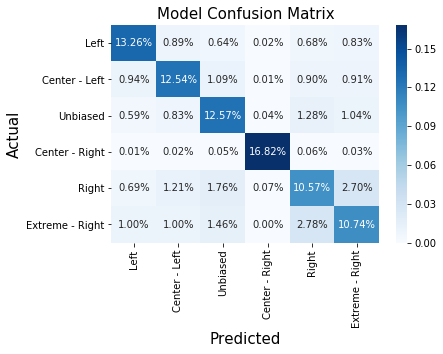

In [34]:
score_model(SVModel)